<a href="https://colab.research.google.com/github/kaito-fujisawa152/Kaggle_AI-Mathematical-Olympiad---Progress-Prize-3/blob/main/Titanic01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [25]:
# 1. データの読み込み
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/test.csv')

In [26]:
# 2. データの補完・加工
def preprocess_titanic(train_df, test_df):
    # データのコピー（元のデータを書き換えないため）
    train = train_df.copy()
    test = test_df.copy()

    # 1. 統計量の算出（Trainデータから計算する）
    age_median = train['Age'].median()
    fare_median = train['Fare'].median()
    embarked_mode = train['Embarked'].mode()[0]

    # 2. 前処理（TrainとTestの両方に適用）
    for df in [train, test]:
        # --- 欠損値補完 ---
        df['Age'] = df['Age'].fillna(age_median)
        df['Fare'] = df['Fare'].fillna(fare_median)
        df['Embarked'] = df['Embarked'].fillna(embarked_mode)
        df['Cabin'] = df['Cabin'].fillna('Unknown')

        # --- 特徴量エンジニアリング ---
        # 性別
        df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

        # 家族人数
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

        # 敬称 (Title)
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
        df['Title'] = df['Title'].map(title_mapping).fillna(0)

        # ビン詰め (Age, Fare)
        # ※注: pd.qcutはTrainの境界値をTestに適用するのが難しいため、ここでは簡易的に数値化
        df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3]).astype(int)
        df['AgeBin'] = pd.cut(df['Age'].astype(int), 5, labels=[0, 1, 2, 3, 4]).astype(int)

        # Deck
        df['Deck'] = df['Cabin'].str[0]

    # --- One-Hot Encoding (EmbarkedとDeck) ---
    # get_dummiesを適用（TrainとTestで列がズレないよう一気に行う工夫）
    # ※実務ではもっと複雑な方法をとりますが、コンペの基本としてはこれが楽です
    combined = pd.concat([train, test], sort=False)
    combined = pd.get_dummies(combined, columns=['Embarked', 'Deck'], prefix=['Embarked', 'Deck'])

    # 再びTrainとTestに切り分ける
    train_processed = combined[combined['Survived'].notnull()].copy()
    test_processed = combined[combined['Survived'].isnull()].drop(['Survived'], axis=1).copy()

    return train_processed, test_processed

train_final, test_final = preprocess_titanic(train_df, test_df)

<>:28: SyntaxWarning: invalid escape sequence '\.'
<>:28: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-2092041651.py:28: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [27]:
# 学習に使用する列（特徴量）のリスト
features = [
    'Pclass', 'Sex', 'AgeBin', 'FareBin',
    'FamilySize', 'Title',
    'Embarked_C', 'Embarked_Q', 'Embarked_S',
    'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U'
]

# preprocess_titanic 関数を呼び出し、結果を train_final と test_final に代入
train_final, test_final = preprocess_titanic(train_df, test_df)

# 学習データの準備
X = train_final[features]        # 説明変数（ヒント）
y = train_final['Survived']     # 目的変数（答え）

# テストデータの準備
X_test = test_final[features]

In [28]:
# 4. モデルの作成と学習
# モデルの作成
# n_estimators: 作成する決定木の数
# max_depth: 木の深さ（深くしすぎると過学習＝練習問題だけに強くなるので注意）
model = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)

# 学習（Fit）
model.fit(X, y)

# 【重要】交差検証（Cross Validation）でモデルの本当の実力を測る
# データを5つに分けて、代わる代わるテストを行う手法です
scores = cross_val_score(model, X, y, cv=5)
print(f"平均正解率: {scores.mean():.2%}")

平均正解率: 82.49%


In [29]:
# 5. 予測
# テストデータで予測
test_predictions = model.predict(X_test)

# 提出用のデータフレーム作成
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": test_predictions.astype(int)
})

# CSV保存
submission.to_csv('my_submission_depth7.csv', index=False)
print("提出用ファイル 'my_submission_depth7.csv' を作成しました！")

提出用ファイル 'my_submission_depth7.csv' を作成しました！


In [30]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
# 全体の欠損値の件数を表示
print(train_df.isnull().sum())
print(test_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [32]:
# 基本統計量の表示
# count：件数 mean：平均値 std：標準偏差
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


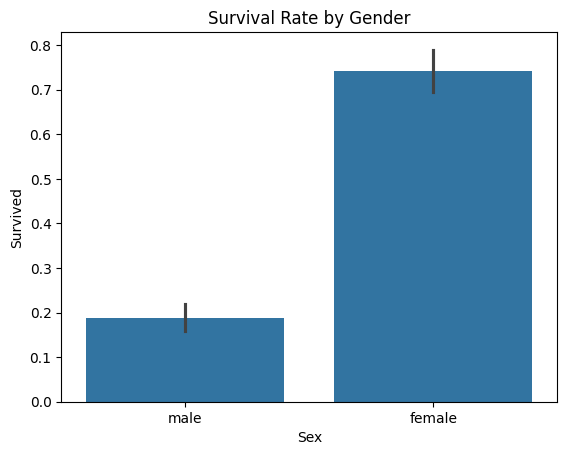

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 性別ごとの生存率を可視化
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title('Survival Rate by Gender')
plt.show()

<Axes: >

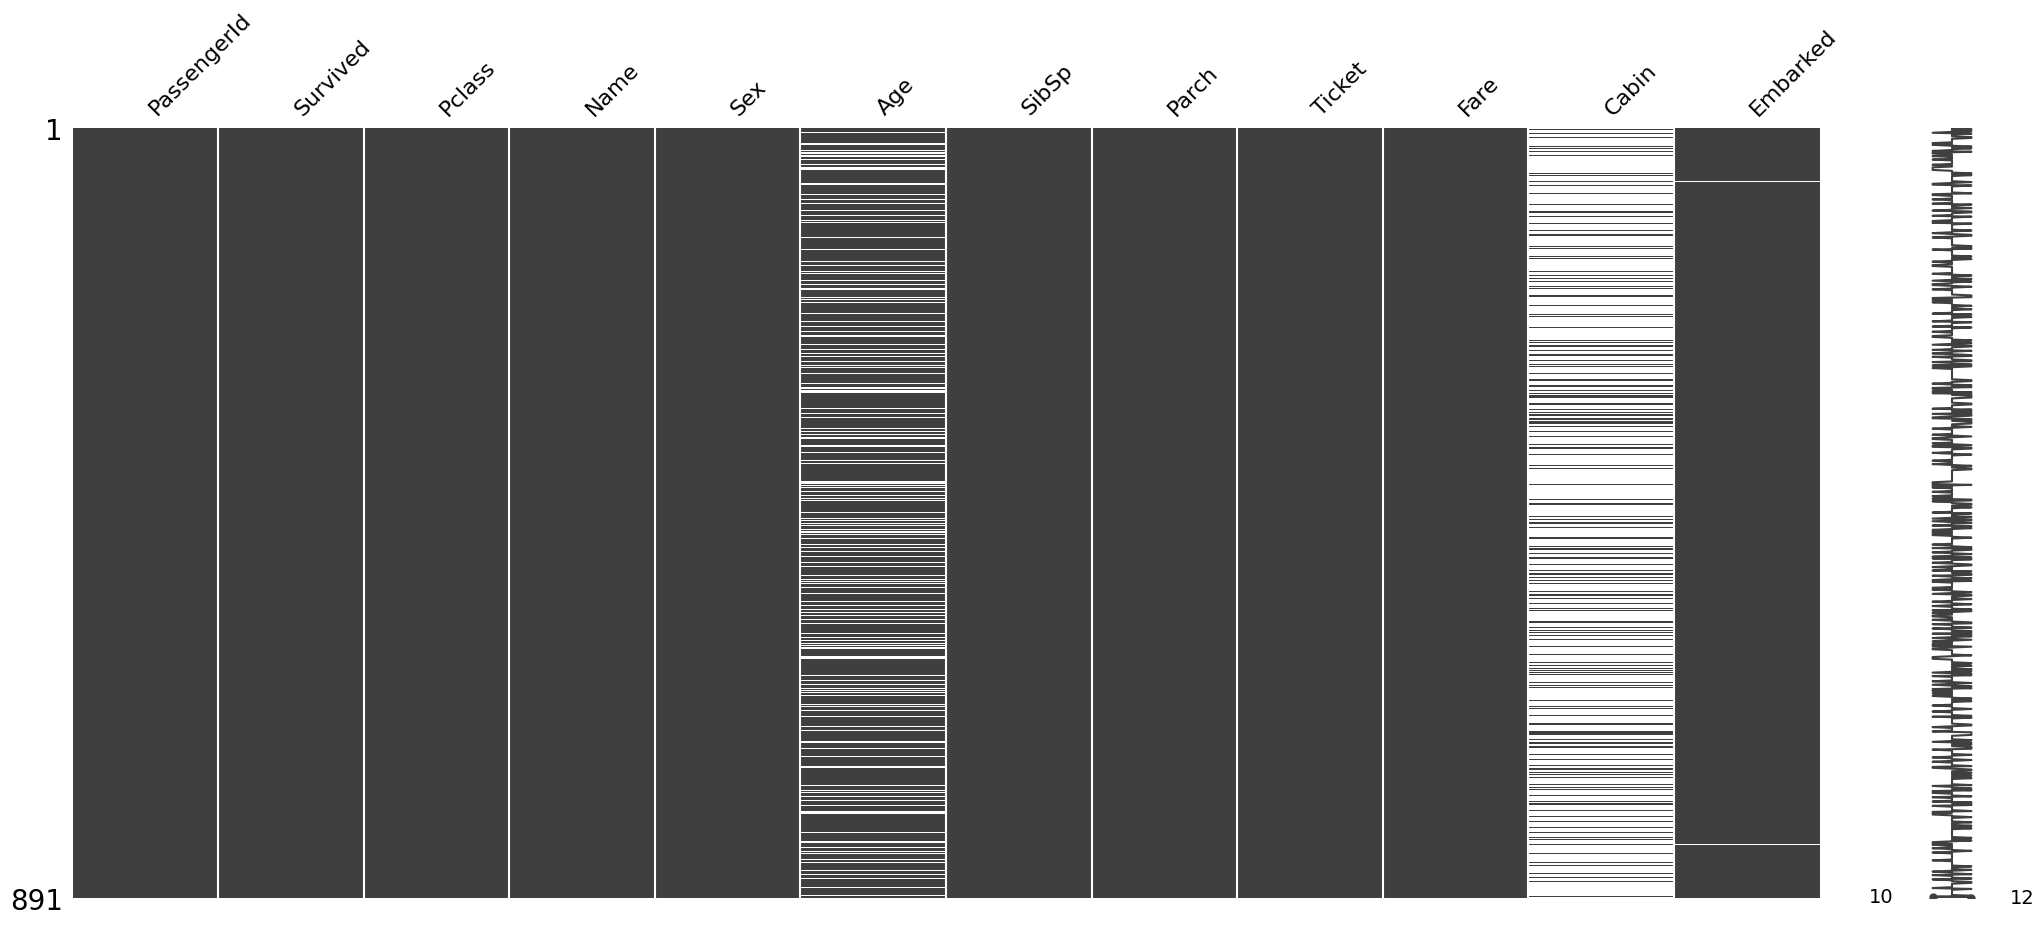

In [34]:
import missingno as msno

# 欠損値の場所をマトリックス状に表示
msno.matrix(train_df)